In [1]:
%load_ext autoreload
%autoreload 2

import datetime

import numpy as np
import pandas as pd
import gudhi

from traffic.core import Traffic, Flight
from functions.data_filtering import ICAO_codes, large_gap_filter
from functions.data_processing import flight_pers, remove_outliers_z_score, remove_outliers_dbscan
from functions.data_loading import linkage_cluster_persistances, flights_from_query

from scipy.cluster.hierarchy import fcluster

Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\19c7a2304988e7a0c4808e46e4601fd7.parquet created on 1732648721.139601
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\dcdf472ad0eae527389b057157e0ddb7.parquet created on 1732648796.8783686
Removing C:\Users\tobso\AppData\Local\opensky\opensky\Cache\ffe63ebaf2a3029b11ea8696bf09e49a.parquet created on 1732648883.5574782


In [2]:
# load minimum data set
df = pd.read_csv("../../data/go_arounds_augmented.csv", low_memory=False)
df["time"] = pd.to_datetime(df["time"])

start = datetime.datetime(year=2019, month=1, day=1).replace(
    tzinfo=datetime.timezone.utc
)
stop = datetime.datetime(year=2019, month=2, day=1).replace(
    tzinfo=datetime.timezone.utc
)

with_GA = df.query(f"has_ga & (@start <= time <= @stop)")
without_GA = df.query(f"not has_ga & (@start <= time <= @stop)")

In [3]:
# The flights can be converted into a Traffic object
count = with_GA.shape[0]
with_GA_flights = flights_from_query(with_GA, count, "../../data/with_GA_flights.pkl", load_results=False)
without_GA_flights = flights_from_query(without_GA, count, "../../data/without_GA_flights.pkl", load_results=False)


0.00% [00:00, ?%/s]
FINISHED: : 0.00% [00:00, ?%/s]
FINISHED: : 100% [00:00, 909%/s]
FINISHED: : 100% [00:00, 901%/s]
FINISHED: : 100% [00:00, 469%/s]

DOWNLOAD: 1.04klines [00:00, 259klines/s]
 96%|█████████▌| 2463/2577 [3:16:48<09:33,  5.03s/it]
0.00% [00:00, ?%/s]
FINISHED: : 0.00% [00:00, ?%/s]
FINISHED: : 100% [00:00, 623%/s]

DOWNLOAD: 979lines [00:00, 245klines/s]A
 96%|█████████▌| 2464/2577 [3:16:51<08:47,  4.67s/it]
0.00% [00:00, ?%/s]
FINISHED: : 0.00% [00:00, ?%/s]
FINISHED: : 100% [00:00, 909%/s]

DOWNLOAD: 1.08klines [00:00, 269klines/s]
 96%|█████████▌| 2465/2577 [3:16:54<07:44,  4.15s/it]
0.00% [00:00, ?%/s]
RUNNING: : 0.00% [00:00, ?%/s]
RUNNING: : 63.0% [00:00, 622%/s]
RUNNING: : 63.0% [00:00, 622%/s]
RUNNING: : 63.0% [00:00, 622%/s]
FINISHED: : 63.0% [00:00, 182%/s]

DOWNLOAD: 1.21klines [00:00, 373klines/s]
 96%|█████████▌| 2466/2577 [3:16:58<07:12,  3.90s/it]
0.00% [00:00, ?%/s]
FINISHED: : 0.00% [00:00, ?%/s]
FINISHED: : 100% [00:00, 792%/s]

DOWNLOAD: 1.23klines 

In [4]:
with_GA_flights = list(filter(large_gap_filter, with_GA_flights))
without_GA_flights = list(filter(large_gap_filter, without_GA_flights))

with_GA_labels = np.ones(len(with_GA_flights))
without_GA_labels = np.zeros(len(without_GA_flights))

flights = with_GA_flights + without_GA_flights
labels = np.concatenate((with_GA_labels, without_GA_labels))

trees, paths = flight_pers(flights)

100%|██████████| 3935/3935 [01:49<00:00, 35.82it/s]


In [6]:
print(len(with_GA_flights))
print(len(without_GA_flights))

1975
1960


In [7]:
path = f"../../data/linkage_clustering/cyclic_dataset.pkl"
Z = linkage_cluster_persistances(trees, path=path, dimension=1, load_results=True)

In [8]:
clustering = fcluster(Z, t=10, criterion='maxclust')

for i in range(1, len(np.unique(clustering))+1):
    print(f"{i}: {sum(clustering == i)}")

1: 10
2: 1
3: 1314
4: 1
5: 19
6: 25
7: 5
8: 12
9: 1
10: 1


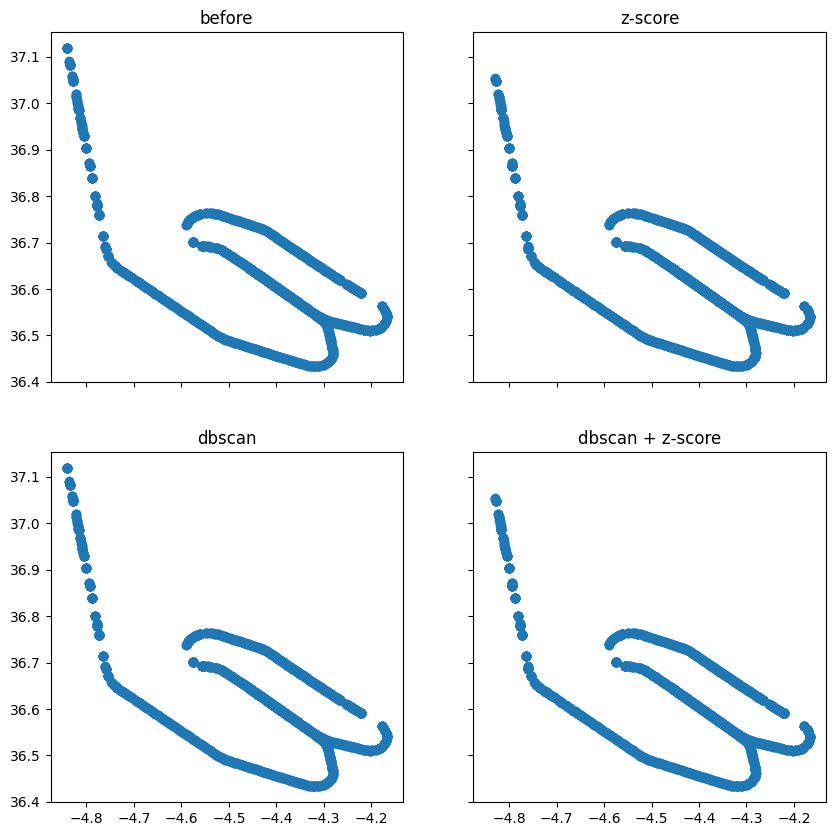

In [9]:
from matplotlib import pyplot as plt

ind = 8

flight = flights[np.where(clustering == ind)[0][4]]
before = flight.data[["longitude", "latitude"]].to_numpy()

dbscan_paths        = before[remove_outliers_dbscan(before, 10)]
z_score_paths       = before[remove_outliers_z_score(before)]
both_bethods_paths  = dbscan_paths[remove_outliers_z_score(dbscan_paths)]

path_filters = [(before, "before"), (z_score_paths, "z-score"), (dbscan_paths, "dbscan"), (both_bethods_paths, "dbscan + z-score")]

fig, axs = plt.subplots((len(path_filters)+1)//2, 2, sharex=True, sharey=True)
for i, (path, name) in enumerate(path_filters):
    axs[i//2, i%2].scatter(path[:, 0], path[:, 1])
    axs[i//2][i%2].set_title(name)

fig.set_figheight(10)
fig.set_figwidth(10)

In [10]:
tree = trees[np.where(clustering == ind)[0][4]]
points = paths[np.where(clustering == ind)[0][4]]
gudhi.plot_persistence_diagram(tree.persistence())

AttributeError: 'numpy.ndarray' object has no attribute 'persistence'

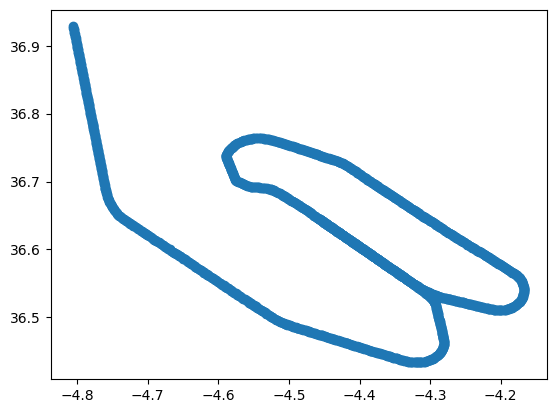

In [11]:
fig = plt.scatter(points[:, 1], points[:, 0])
plt.show()